### Referred Paper
> Retinal Disease Classification from OCT Images Using Deep Learning Algorithms
> Abstract: 
Optical Coherence Tomography (OCT) is a noninvasive test that takes cross-section pictures of the retina layer of the eye and allows ophthalmologists to diagnose based on the retina's layers. Therefore, it is an important modality for the detection and quantification of retinal diseases and retinal abnormalities. Since OCT provides several images for each patient, it is a time consuming work for ophthalmologists to analyze the images. This paper proposes deep learning models that categorize patients' OCT images into four categories such as Choroidal neovascularization (CNV), Diabetic macular edema (DME), Drusen, and Normal. Two different models are proposed. One is using three binary Convolutional Neural Network (CNN) classifiers and the other is using four binary CNN classifiers. Several CNNs, such as VGG16, VGG19, ResNet50, ResNet152, DenseNet121, and InceptionV3, are adapted as feature extractors to develop the binary classifiers. Among them, the proposed model using VGG16 for CNV vs. Other classes, VGG16 for DME vs. other classes, VGG19 for Drusen vs. Other classes, and InceptionV3 for Normal vs. other classes shows the best performance with 0.987 accuracy, 0.987 sensitivity, and 0.996 specificity. The binary classifier for Normal class has 0.999 accuracy. These results show their potential to work as a second reader for ophthalmologists.
> Link: https://ieeexplore.ieee.org/abstract/document/9562919

#### The above research paper used various models on the dataset such as VGG16, Resnet etc.<br> But I will be using InceptionResnetV2 model for Retinal disease classification

## The dataset used
#### Retinal Disease Classification
> Link: https://www.kaggle.com/datasets/andrewmvd/retinal-disease-classification/ 

In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
from keras.preprocessing import image
pd.options.display.max_columns = 50
from sklearn.model_selection import KFold

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay

In [4]:
#imported models for testing
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

In [5]:
#image dimensions given to the model
img_width = 150
img_height = 150
img_channels = 3

In [6]:
#This dude uses dataframes instead of loading images manually, i'm not sure if dataframes are a must when dealing with medical datasets or not
train_df = pd.read_csv('/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/RFMiD_Training_Labels.csv')
val_df = pd.read_csv('/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv')
test_df = pd.read_csv('/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/RFMiD_Testing_Labels.csv')

In [7]:
#This adds image path for each corresponding id, since the csv lists image number(id) and its relevant disease
train_df['img_path'] = [f'/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/Training/{id}.png' for id in train_df['ID']]
val_df['img_path'] = [f'/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/Validation/{id}.png' for id in val_df['ID']]
test_df['img_path'] = [f'/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test/{id}.png' for id in test_df['ID']]

In [8]:
#excess data, dropped.
#Disease risk isn't helpful to the model, so it've been removed.
#ODPM and HR are not available in this dataset so they've been removed

train_df = train_df.drop(labels=['ID','ODPM', 'HR'], axis=1)
val_df = val_df.drop(labels=['ID', 'ODPM', 'HR'], axis=1)
test_df = test_df.drop(labels=['ID', 'ODPM', 'HR'], axis=1)

In [9]:
Y_train = ['Disease_Risk']
Y_val = ['Disease_Risk']
Y_test = ['Disease_Risk']
# unq_disease = len(Y_train)

In [10]:
#sets the preprocessing data of the images before passing it into the dataset
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rotation_range=90,
                                                                brightness_range=[0, 0.1],
                                                                preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [11]:
test_gen = test_datagen.flow_from_dataframe(test_df,
                                            x_col='img_path',
                                            y_col=Y_test,
                                            target_size=(150,150),
                                            class_mode='raw',
                                            batch_size=8)

Found 640 validated image filenames.


In [12]:
def transfer_model_generator():
    pre_trained_model = InceptionResNetV2(
                                input_shape = (img_width,img_height, img_channels), 
                                include_top = False, 
                                weights = None)
    for layer in pre_trained_model.layers:
        layer.trainable = False
    last_layer = pre_trained_model.get_layer("mixed_7a")
    print('last layer output shape: ', last_layer.output_shape)
    last_output = last_layer.output
    #adding a binary classification layer 
    x = layers.Flatten()(last_output)
    x = layers.Dense(1024, activation='relu')(x)
    #dense(1) creates a single neuron alongside sigmoid which is responsible for the binary classification
    x = layers.Dense (1, activation='sigmoid')(x)
    return Model(pre_trained_model.input, x)

In [13]:
def custom_model_generator():
    return Sequential([
        Conv2D(64, (3,3), 1, activation='relu', input_shape=(img_width,img_height, img_channels)),
        MaxPooling2D(),
        Conv2D(32, (3,3), 1, activation='relu'),
        MaxPooling2D(),
        Conv2D(64, (3,3), 1, activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

In [14]:
#parameter arrays for each model and its outputs
transfer_models = []
custom_models = []

transfer_histories = []
custom_histories = []

transfer_errors = []
custom_errors = []

transfer_accuracies = []
custom_accuracies = []

In [15]:
#model fitting parameters
steps_per_epoch = 20
epochs = 10
validation_steps = 5

#folding parameters
n_splits = 3
k_folds = KFold(n_splits = n_splits)

#combine both training and validation dataframes
dataset = pd.concat([train_df, val_df], ignore_index=True)
#iterations
itr=0

In [16]:
for train_dfk,val_dfk in k_folds.split(dataset):
    print(f'This is iteration number: {itr +1}')
    #prepare the dataset
    print("preparing the dataset")
    print("----------------------------------------------------------")
    train_genf = train_datagen.flow_from_dataframe(dataset.iloc[train_dfk], 
                                              x_col='img_path', 
                                              y_col=Y_train,
                                              target_size=(img_width,img_height),
                                              class_mode='raw',
                                              batch_size=32,
                                              shuffle=False)
    val_genf = test_datagen.flow_from_dataframe(dataset.iloc[val_dfk],
                                                x_col='img_path',
                                                y_col=Y_test,
                                                target_size=(img_width,img_height),
                                                class_mode='raw',
                                               batch_size=16)
    #generate new untrained models and add them to their respective arrays
    print("Generating the models")
    print("----------------------------------------------------------")
    transfer_models.append(transfer_model_generator())
    custom_models.append(custom_model_generator())
    #compile the model
    print("Compiling the models")
    print("----------------------------------------------------------")
    transfer_models[-1].compile(optimizer = RMSprop(learning_rate=0.00001),loss = 'binary_crossentropy', metrics = ['accuracy'])
    custom_models[-1].compile(optimizer = RMSprop(learning_rate=0.00001),loss = 'binary_crossentropy', metrics = ['accuracy'])
    #fit the model and save its history
    print("Fitting the models")
    print("----------------------------------------------------------")
    print("fitting the transfer model")
    transfer_histories.append(transfer_models[-1].fit(train_genf, validation_data = val_genf, steps_per_epoch=steps_per_epoch,epochs =epochs,validation_steps=validation_steps))
    print("fitting the custom model")
    custom_histories.append(custom_models[-1].fit(train_genf, validation_data = val_genf, steps_per_epoch=steps_per_epoch,epochs =epochs,validation_steps=validation_steps))
    #evaluate the model and get the accuracies
    print("Calculating the accuracy of each model")
    print("----------------------------------------------------------")
    print("Calculating the accuracy of the transfer model")
    error, acc = transfer_models[-1].evaluate(test_gen)
    transfer_errors.append(error)
    transfer_accuracies.append(acc)
    print("Calculating the accuracy of the custom model")
    #preventing out of bounds error by seperating the error and accuracy matricies.
    error, acc = custom_models[-1].evaluate(test_gen)
    custom_errors.append(error)
    custom_accuracies.append(acc)
    print(f'iteration number {itr +1} is done.')
    print("----------------------------------------------------------")
    print("----------------------------------------------------------")
    itr+=1

This is iteration number: 1
preparing the dataset
----------------------------------------------------------
Found 1706 validated image filenames.
Found 854 validated image filenames.
Generating the models
----------------------------------------------------------
last layer output shape:  (None, 3, 3, 2080)
Compiling the models
----------------------------------------------------------
Fitting the models
----------------------------------------------------------
fitting the transfer model
Epoch 1/10
20/20 [==============================] - 111s 5s/step - loss: 0.6928 - accuracy: 0.7156 - val_loss: 0.6861 - val_accuracy: 0.9125
Epoch 2/10
20/20 [==============================] - 71s 4s/step - loss: 0.6919 - accuracy: 0.8016 - val_loss: 0.6862 - val_accuracy: 0.8500
Epoch 3/10
20/20 [==============================] - 100s 5s/step - loss: 0.6914 - accuracy: 0.7953 - val_loss: 0.6859 - val_accuracy: 0.8250
Epoch 4/10
20/20 [==============================] - 75s 4s/step - loss: 0.6911 - ac

In [17]:
#selecting the transfer model with the highest accuracy
selected_transfer_index = np.argmax(transfer_accuracies)

print(f'The best model was found at fold = {selected_transfer_index}')

selected_transfer_model = transfer_models[selected_transfer_index]

selected_transfer_history = transfer_histories[selected_transfer_index]

selected_transfer_accuracy = transfer_accuracies[selected_transfer_index]

selected_transfer_predictions = selected_transfer_model.predict(test_gen, verbose=1)

The best model was found at fold = 0
80/80 [==============================] - 79s 969ms/step


In [18]:
#selecting the custom model with the highest accuracy
selected_custom_index = np.argmax(custom_accuracies)

print(f'The best model was found at fold = {selected_custom_index}')

selected_custom_model = custom_models[selected_custom_index]

selected_custom_history = custom_histories[selected_custom_index]

selected_custom_accuracy = custom_accuracies[selected_custom_index]

selected_custom_predictions = selected_custom_model.predict(test_gen, verbose=1)

The best model was found at fold = 0
80/80 [==============================] - 77s 972ms/step


In [19]:
#sequentially iterates through the array to find if eye is diseased or not.
#yes, we could've used argmax on test_gen.labels. but we didn't.
diseased_labels = []
for i in test_gen.labels:
    if(i.any() == 1):
        diseased_labels.append(1)
    else:
        diseased_labels.append(0)

In [20]:
# uses the average to create a threshold for custom model
transfer_thres = np.average(selected_transfer_predictions)
transfer_y_pred = (selected_transfer_predictions > transfer_thres)*1
print("custom model threshold: ",transfer_thres)

custom model threshold:  0.5093669


The transfer model confusion matrix


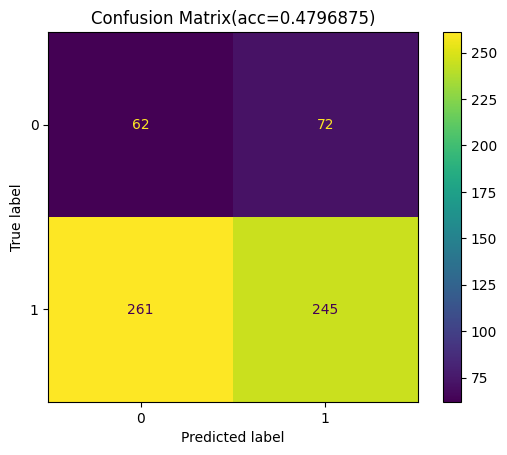

In [21]:
print("The transfer model confusion matrix")
transfer_acc = accuracy_score(diseased_labels, transfer_y_pred)
transfer_cm = confusion_matrix(diseased_labels, transfer_y_pred)
transfer_disp = ConfusionMatrixDisplay(transfer_cm)
transfer_disp.plot()
plt.title(f'Confusion Matrix(acc={transfer_acc})')
plt.show()

In [22]:
# uses the average to create a threshold for custom model
custom_thres = np.average(selected_custom_predictions)
custom_y_pred = (selected_custom_predictions > custom_thres)*1
print("custom model threshold: ",custom_thres)

custom model threshold:  0.49776942


The custom model confusion matrix


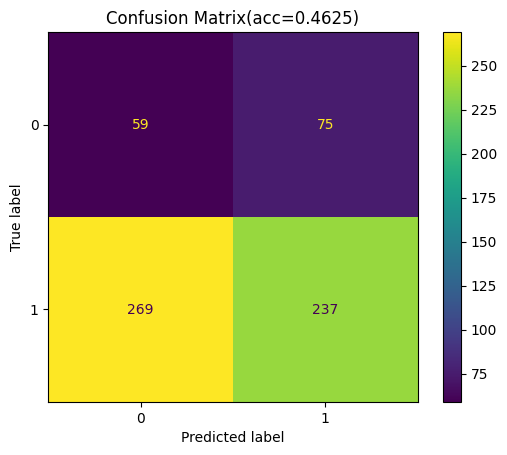

In [23]:
print("The custom model confusion matrix")
transfer_acc = accuracy_score(diseased_labels, custom_y_pred)
transfer_cm = confusion_matrix(diseased_labels, custom_y_pred)
transfer_disp = ConfusionMatrixDisplay(transfer_cm)
transfer_disp.plot()
plt.title(f'Confusion Matrix(acc={transfer_acc})')
plt.show()

The transfer model graphical representation of the accuracy


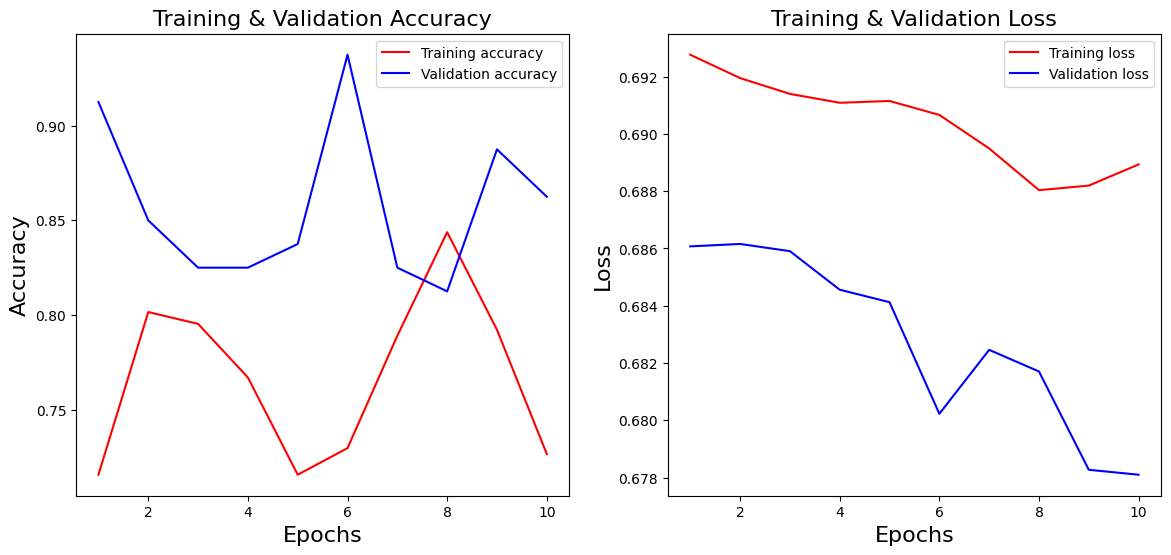

In [24]:
print("The transfer model graphical representation of the accuracy")
history_dict = selected_transfer_history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

The custom model graphical representation of the accuracy


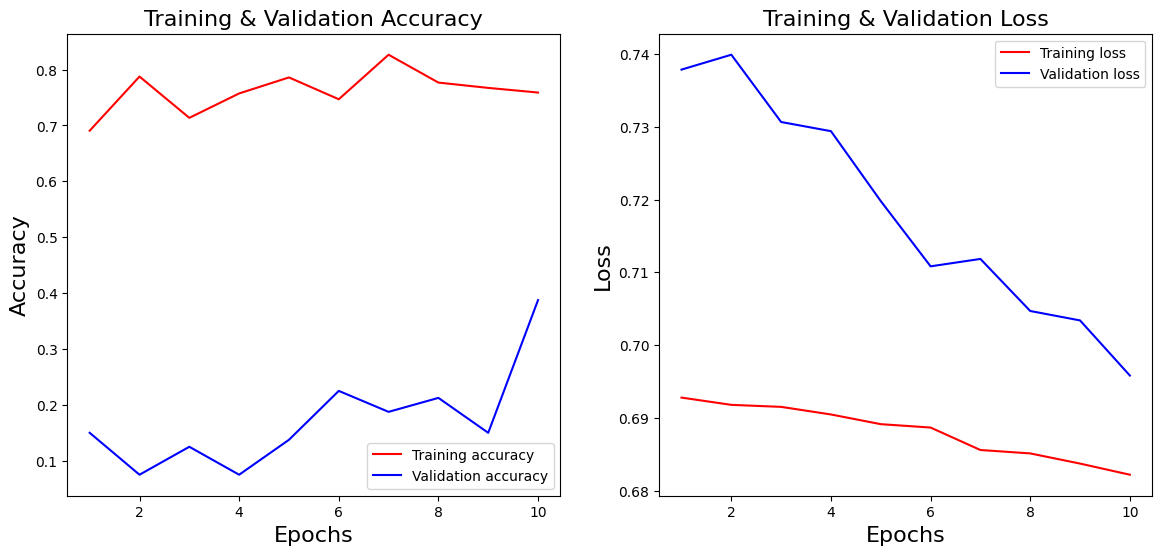

In [25]:
print("The custom model graphical representation of the accuracy")
history_dict = selected_custom_history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()